# Word2vec con Los Simpsons

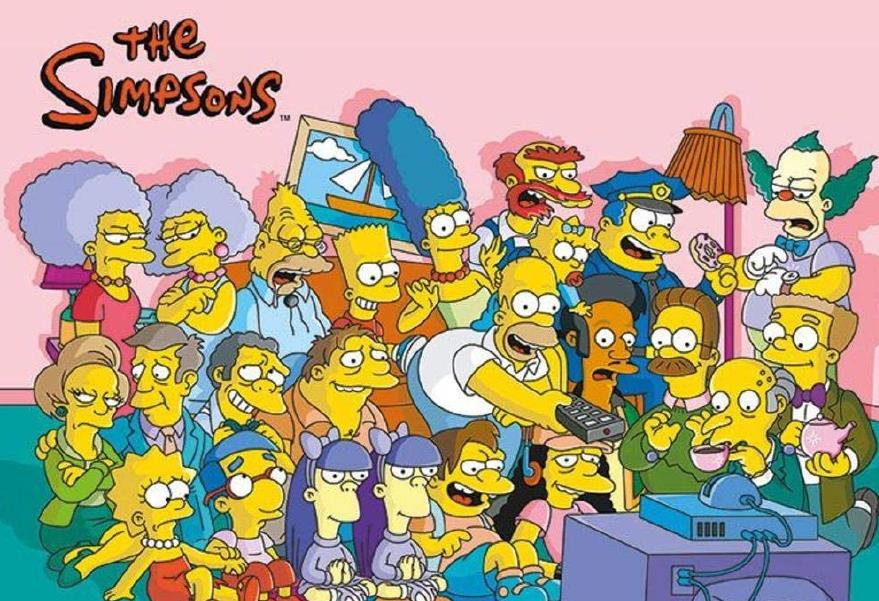

En este notebook vamos a entrenar un modelo de Word embeddings con datos de Los Simpsons (guiones de varias temporadas, cerca de 150 mil lineas de dialogo para unos 600 episodios) y tratar de entender los resultados.




# Cargado y procesado de texto

Montamos el Drive y cargamos los datos:

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/My Drive/LaboDatos2021/simpsons_dataset.csv'
df = pd.read_csv(filename)


Mounted at /content/drive


Veamos un poco de lo que contiene el dataframe:

In [ ]:
print(df.shape)
print(df.head())
print(df['raw_character_text'].value_counts())


(158314, 2)
        raw_character_text                                       spoken_words
0              Miss Hoover  No, actually, it was a little of both. Sometim...
1             Lisa Simpson                             Where's Mr. Bergstrom?
2              Miss Hoover  I don't know. Although I'd sure like to talk t...
3             Lisa Simpson                         That life is worth living.
4  Edna Krabappel-Flanders  The polls will be open from now until the end ...
Homer Simpson              29782
Marge Simpson              14141
Bart Simpson               13759
Lisa Simpson               11489
C. Montgomery Burns         3162
                           ...  
Soccer Mummy                   1
Voice #2                       1
IRISH PETE                     1
Fat Cheeked Housekeeper        1
Catholic Leprechaun            1
Name: raw_character_text, Length: 6758, dtype: int64


Hay valores faltantes en la primera columna que tienen que ver con dialogo que no es provisto por ninguno de los personajes, por ejemplo, voces en off, etc. Podemos removerlo como sigue:

In [ ]:
print(df.isnull().sum())
df = df.dropna().reset_index(drop=True)
print(df.isnull().sum())


raw_character_text    17814
spoken_words          26459
dtype: int64
raw_character_text    0
spoken_words          0
dtype: int64


Ahora, vamos a limpiar el texto. Empezamos implementando la funcion que vimos en el notebook de procesado de texto para remover simbolos, pasar a minuscilas, etc.

Pero hay una diferencia: en el idioma inglés, el símbolo ' se usa para contracciones, y si lo removemos sin expandir las contracciones perdemos informacion. Por lo tanto, antes vamos a lidiar con las contracciones usando la muy util libreria "contractions"

In [ ]:
!pip install contractions # instalamos
import contractions # importamos

print(contractions.fix("You've")) # algunos ejemplos
print(contractions.fix("Homer's car"))
print(contractions.fix("Wouldn't ain't won't"))

# Defino una funcion anonima que al pasarle un argumento devuelve el resultado de aplicarle la funcion anterior a este mismo argumento
round0 = lambda x: contractions.fix(x)

# Dataframe que resulta de aplicarle a las columnas la funcion de limpieza
data_clean = pd.DataFrame(df.spoken_words.apply(round0))


     |████████████████████████████████| 286kB 5.1MB/s 
     |████████████████████████████████| 327kB 36.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85407 sha256=a867adc0df12318a0288ea8c178bb2125eb3f721000f87912c7a93b1ea6ef8ef
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
you have
Homer's car
would not are not will not


Veamos como va quedando:

In [ ]:
data_clean['spoken_words']

0         No, actually, it was a little of both. Sometim...
1                                   where is Mr. Bergstrom?
2         I do not know. Although I would sure like to t...
3                                That life is worth living.
4         The polls will be open from now until the end ...
                                ...                        
131848                                           I am back.
131849    You see, class, my Lyme disease turned out to ...
131850                                   Psy-cho-so-ma-tic.
131851                       Does that mean you were crazy?
131852                    No, that means she was faking it.
Name: spoken_words, Length: 131853, dtype: object

Ahora si, removemos la puntuacion:

In [ ]:
import re       # libreria de expresiones regulares
import string   # libreria de cadena de caracteres

# Defino una funcion que recibe un texto y devuelve el mismo texto sin singnos,
def clean_text_round1(text):
    # pasa las mayusculas del texto a minusculas
    text = text.lower()                                              
    # reemplaza texto entre corchetes por espacio en blanco.. ¿ y \% no se..
    text = re.sub('\[.*?¿\]\%', ' ', text)                           
    # reemplaza signos de puntuacion por espacio en blanco.. %s -> \S+ es cualquier caracter que no sea un espacio en blanco
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    # remueve palabras que contienen numeros.
    text = re.sub('\w*\d\w*', '', text)                              
    return text

# Defino una funcion anonima que al pasarle un argumento devuelve el resultado de aplicarle la funcion anterior a este mismo argumento
round1 = lambda x: clean_text_round1(x)

# Dataframe que resulta de aplicarle a las columnas la funcion de limpieza
data_clean = pd.DataFrame(data_clean.spoken_words.apply(round1))

Veamos como quedó luego de este segundo paso de limpieza:

In [ ]:
data_clean['spoken_words']

0         no  actually  it was a little of both  sometim...
1                                   where is mr  bergstrom 
2         i do not know  although i would sure like to t...
3                                that life is worth living 
4         the polls will be open from now until the end ...
                                ...                        
131848                                           i am back 
131849    you see  class  my lyme disease turned out to ...
131850                                   psy cho so ma tic 
131851                       does that mean you were crazy 
131852                    no  that means she was faking it 
Name: spoken_words, Length: 131853, dtype: object

Siguiendo con el proceso en el notebook de la clase anterior, hacemos una tercera ronda de limpieza, donde removemos comillas y puntos suspensivos.

In [ ]:
# Hacemos una segunda vuelta de limpieza
def clean_text_round2(text):
    # Sacamos comillas, los puntos suspensivos, <<, >>
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text
 
round2 = lambda x: clean_text_round2(x)
 
data_clean = pd.DataFrame(data_clean.spoken_words.apply(round2))

A continuacion, vamos a armar una funcion que transforme a cada linea de dialogo en una lista de palabras, separandola por espacios, y luego remueva los stopwords presentes en esa lista. Finalmente, volveremos a unir la lista con espacios.

No vamos a lematizar con pos tagging porque podria llevar demasiado tiempo. Usamos el lematizador de wordnet como viene, lo cual es util para algunas cosas nada mas (ej., pasar de plural a singular)

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() # funcion para lematizar
nltk.download('stopwords') # hay que descargar este modulo en particular
sw = nltk.corpus.stopwords.words('english') # lista de stopwords
print(sw)

def remove_sw(text):
  words = text.split(' ') # separamos por espacios
  words_clean = []
  for w in words:
    if not w in sw: # si no es stopword, agregamos la version lematizada
      words_clean.append(lemmatizer.lemmatize(w))
  return ' '.join(words_clean)

round3 = lambda x: remove_sw(x)
 
data_final =  pd.DataFrame(data_clean.spoken_words.apply(round3))

data_final

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'ov

,spoken_words
0,actually little sometimes disease magazine ...
1,mr bergstrom
2,know although would sure like talk touch les...
3,life worth living
4,poll open end recess case decided put though...
...,...
131848,back
131849,see class lyme disease turned
131850,psy cho tic
131851,mean crazy


# Entrenamiento de word2vec

Ahora vamos a usar la libreria gensim para lo que resta. 

Primero, vamos a separar los strings en listas (de nuevo) y pasarlo por una funcion de gensim que transforma el texto para incluir a los bigramas (combinaciones de dos palabras) mas frecuentes en el texto.

In [ ]:
from gensim.models.phrases import Phrases, Phraser

input = [row.split() for row in data_final['spoken_words']] # separamos en una lista

phrases = Phrases(input, min_count=30, progress_per=1000) 

bigram = Phraser(phrases)

sentences = bigram[input] # obtenemos las palabras junto con bigramas



El siguiente paso consta de entrenar el modelo word2vec con los datos. Para eso, le pasamos una serie de parametros que estan explicados en el codigo siguiente.

In [ ]:
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=20, # ignora palabras cuya frecuencia es menor a esta
                     window=2, # tamanio de la ventana de contexto
                     size=300, # dimension del embedding
                     sample=6e-5, # umbral para downsamplear palabras muy frecuentes
                     alpha=0.03, # tasa de aprendizaje inicial (entrenamiento de la red neuronal)
                     min_alpha=0.0007, # tasa de aprendizaje minima
                     negative=20, # penalidad de palabras muy frecuentes o poco informaitvas
                     workers=cores) # numero de cores para entrenar el modelo

w2v_model.build_vocab(sentences, progress_per=10000) # construye el vocabulario

### ENTRENA EL MODELO
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
### PRECOMPUTA DISTANCIAS (mas rapido)
w2v_model.init_sims(replace=True)



# Jugando con el embedding

Listo. Ahora tenemos todas las palabras en los guiones mapeadas a un espacio de dimension 300. Podemos calcular la similitud semantica entre estas palabras usando la distancia coseno entre ellas. 

Esto nos permite hacer queries como por ejemplo, buscar las palabras mas cercanas a alguna en particular:

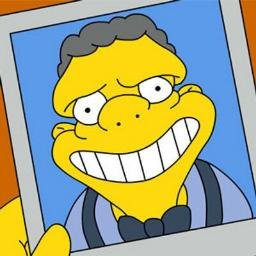

In [ ]:
w2v_model.wv.most_similar(positive=["moe"])


[('szyslak', 0.8409276008605957),
 ('tavern', 0.8177198171615601),
 ('bartender', 0.7998760938644409),
 ('flaming', 0.7537461519241333),
 ('uncle', 0.581324577331543),
 ('thinkin', 0.5746142268180847),
 ('apu', 0.5579429864883423),
 ('homer', 0.5436537861824036),
 ('baron', 0.5436241626739502),
 ('hiya', 0.5413256883621216)]

O por que no...

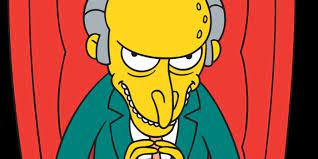

In [ ]:
print(w2v_model.wv.most_similar(positive=["burn"]))
print(w2v_model.wv.most_similar(positive=["monty"]))

[('monty', 0.8393440246582031), ('colonel', 0.5597219467163086), ('witch', 0.5137960910797119), ('larry', 0.5133128762245178), ('uniform', 0.5111962556838989), ('routine', 0.49877315759658813), ('mister', 0.4784793257713318), ('yer', 0.4719357490539551), ('casino', 0.47121506929397583), ('shot', 0.4614516496658325)]
[('burn', 0.8393440246582031), ('casino', 0.5289480090141296), ('definitely', 0.5226229429244995), ('mr_burn', 0.5112004280090332), ('lad', 0.5106742978096008), ('wealthy', 0.5090756416320801), ('larry', 0.506951630115509), ('documentary', 0.5060543417930603), ('murderer', 0.5037519931793213), ('whoever', 0.5032395124435425)]


En este caso, notemos que "burns" da error. La palabra no aparece en el vocabulario, porque cuando lematizamos, asumio que era el plural de "burn" y lo cambio. Esto es algo que hay que tener en cuenta cuando trabajamos con nombres propios.

Al haber incluido bigramas en el modelo, podemos hacer queries sobre pares de palabras.

In [ ]:
w2v_model.wv.most_similar(positive=["bart_simpson"])

[('mr_krabappel', 0.7389228343963623),
 ('principal', 0.6853528022766113),
 ('lisa_simpson', 0.6840564012527466),
 ('robert', 0.6806033253669739),
 ('principal_skinner', 0.6805570721626282),
 ('confession', 0.6680616140365601),
 ('university', 0.6556755304336548),
 ('m', 0.6543828248977661),
 ('jr', 0.6537007093429565),
 ('experiment', 0.6486954689025879)]

Podemos, por supuesto, calcular la similitud semantica entre pares de palabras individuales (o bigramas). Por ejemplo, podemos corroborar que la similitud entre:

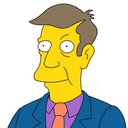

y los dos siguientes

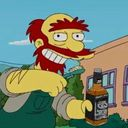

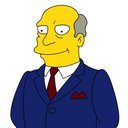

es mayor que con otros personajes de la serie.

In [ ]:
print("Willie")
print(w2v_model.wv.similarity("skinner", 'willie'))
print(w2v_model.wv.similarity("marge", 'willie'))
print(w2v_model.wv.similarity("homer", 'willie'))
print(w2v_model.wv.similarity("bart", 'willie'))
print(w2v_model.wv.similarity("lisa", 'willie'))

print("Inspector Archundia")
print(w2v_model.wv.similarity("skinner", 'chalmers'))
print(w2v_model.wv.similarity("marge", 'chalmers'))
print(w2v_model.wv.similarity("homer", 'chalmers'))
print(w2v_model.wv.similarity("bart", 'chalmers'))
print(w2v_model.wv.similarity("lisa", 'chalmers'))

Willie
0.35896015
0.24051961
0.27980688
0.40336224
0.36210555
Inspector Archundia
0.53319466
0.17227797
0.31705174
0.40852508
0.2823778


Podemos usar el embedding para encontrar el termino que menos encaja con los demas entre estos tres personajes.

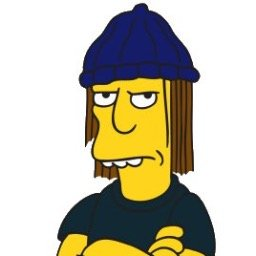

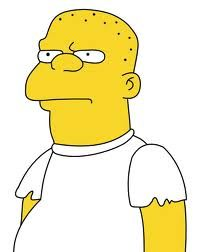

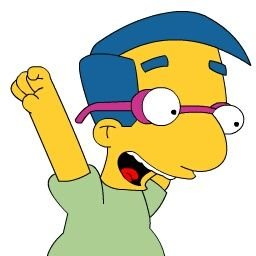

In [ ]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])


/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'milhouse'

Podemos hacer analogias, por ejemplo, ¿Que es a Bart lo que "mujer" es a Lisa?

Para eso, buscamos palabras que esten lo mas cerca posible de "mujer" y "Bart" y lo mas lejos posible de "Lisa".

In [ ]:
w2v_model.wv.most_similar(positive=["woman","bart"], negative=["lisa"], topn=10)

[('wealthy', 0.5716564655303955),
 ('marrying', 0.5427558422088623),
 ('foolish', 0.5385615825653076),
 ('husband', 0.5294201374053955),
 ('common', 0.527266263961792),
 ('man', 0.5255641341209412),
 ('caring', 0.5253580808639526),
 ('younger', 0.5223351716995239),
 ('unfair', 0.5210275053977966),
 ('ashamed', 0.5149030685424805)]

In [ ]:
w2v_model.wv.most_similar(positive=["marge","flanders"], negative=["homer"], topn=10)

[('maude', 0.61692214012146),
 ('neighbor', 0.5738011598587036),
 ('reverend_lovejoy', 0.5310967564582825),
 ('ned_flanders', 0.5202360153198242),
 ('selfish', 0.5050857067108154),
 ('helping', 0.4920114278793335),
 ('demon', 0.49177202582359314),
 ('ned', 0.4858739376068115),
 ('strangle', 0.48023688793182373),
 ('reverend', 0.4768869876861572)]

¿Que es a Apu lo que Marge es a Homero?

In [ ]:
w2v_model.wv.most_similar(positive=["marge","apu"], negative=["homer"], topn=3)

[('manjula', 0.6384023427963257),
 ('arranged', 0.5759750604629517),
 ('earring', 0.5636121034622192)]

¿Qué es a "Mujer" lo que Bart es a "Hombre"?
¿Y lo mismo pero con Homero en vez de Bart?

In [ ]:
print(w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3))
print(w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["man"], topn=3))

[('lisa', 0.6138172149658203), ('grownup', 0.5948721170425415), ('assignment', 0.5802316665649414)]
[('marge', 0.6070239543914795), ('marrying', 0.5396683812141418), ('grownup', 0.5343846082687378)]


Ahora vamos a visualizar el embedding usando TSNE, una tecnica no lineal para reducir la dimension.

Para eso, voy a armar una funcion que plotea con colores diferentes una palabra (rojo), las palabras mas cercanas (azul) y una lista arbitraria de palabras (verde).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):

    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    close_words = model.wv.most_similar([word])
    
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE de {}'.format(word.title()))

Veamos que pasa en el caso de Homero

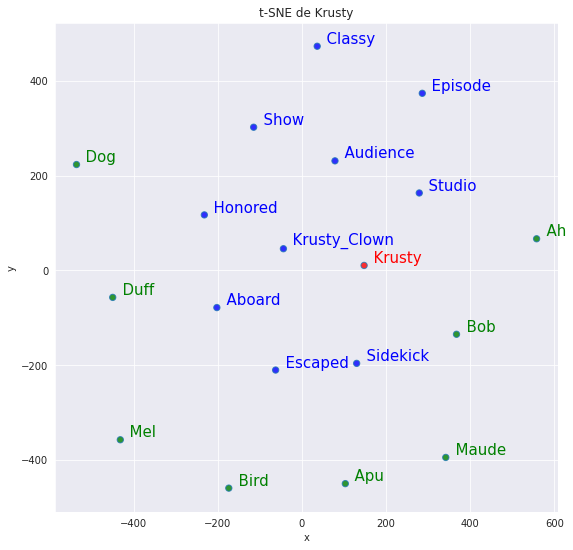

In [ ]:
tsnescatterplot(w2v_model, 'krusty', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

Tambien podemos elegir la lista de palabras arbitrarias para que sean las mas lejanas, entonces visualizamos en un mismo grafico las palabras mas cercanas y las mas lejanas simultaneamente.

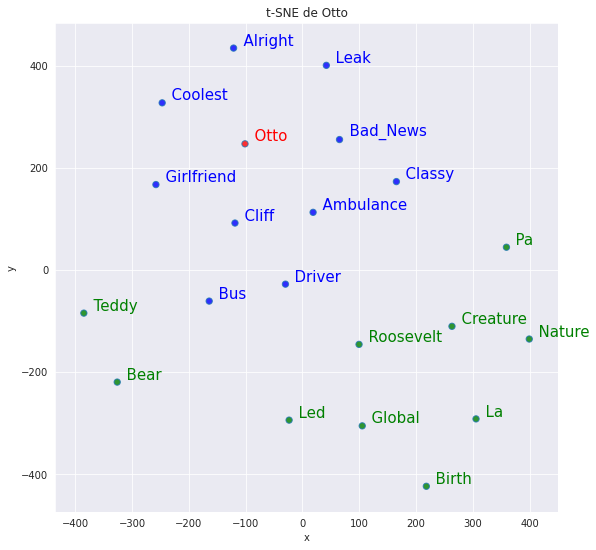

In [ ]:
tsnescatterplot(w2v_model, 'otto', [i[0] for i in w2v_model.wv.most_similar(negative=["otto"])])

# Creditos

Este notebook esta basado en un notebook publicado en Kaggle por Pierre Megret 

```
https://www.kaggle.com/pierremegret
```

